Data processing method:

1) Import packages

2) Load in data

3) Standard cleaning, naming and indexing

4) View raw data as rough scatter plots

5) Remove negative time values

6) Segment heat flow sequences to remove irrelevant ones (main heating and cooling only)

7) Normalise mW to W/g

8) Isolate the heat flow section relevant to the crystallisation for the area peak

9) Final figure plots

10) Peak fitting 

11) Plot with fitted peak

12) Integration to determine crystallisation fraction, avrami exponent and rate constant

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [121]:
filepath = '/Users/thomasfish/Desktop/University_Work/II_Materials/P3_Polymer_Crystallisation/PEO50_cleaned.csv'

df1 = pd.read_csv(filepath, header=None, delimiter='\s+')
df1.columns = ['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%']

for col in ['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%']:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
df1 = df1.dropna(subset=['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%'])

t = df1['Time/m'].to_numpy()
T = df1['Temperature/C'].to_numpy()
HF = df1['Heat_Flow/mW'].to_numpy()
A = df1['Area/%'].to_numpy()

df1.head(-10)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_16842/4150770728.py:3: SyntaxWarning: invalid escape sequence '\s'
  df1 = pd.read_csv(filepath, header=None, delimiter='\s+')


,Time/m,Temperature/C,Heat_Flow/mW,Area/%
0,0.000500,28.64386,-2.428228,0.0
1,0.017167,28.50610,-2.289162,0.0
2,0.033833,28.43012,-2.260929,0.0
3,0.050500,28.42400,-2.324786,0.0
4,0.067167,28.48156,-2.304752,0.0
...,...,...,...,...
4679,77.900500,25.31211,-1.062556,0.0
4680,77.917180,25.29612,-1.022660,0.0
4681,77.933840,25.28906,-0.977872,0.0
4682,77.950500,25.27194,-0.944504,0.0


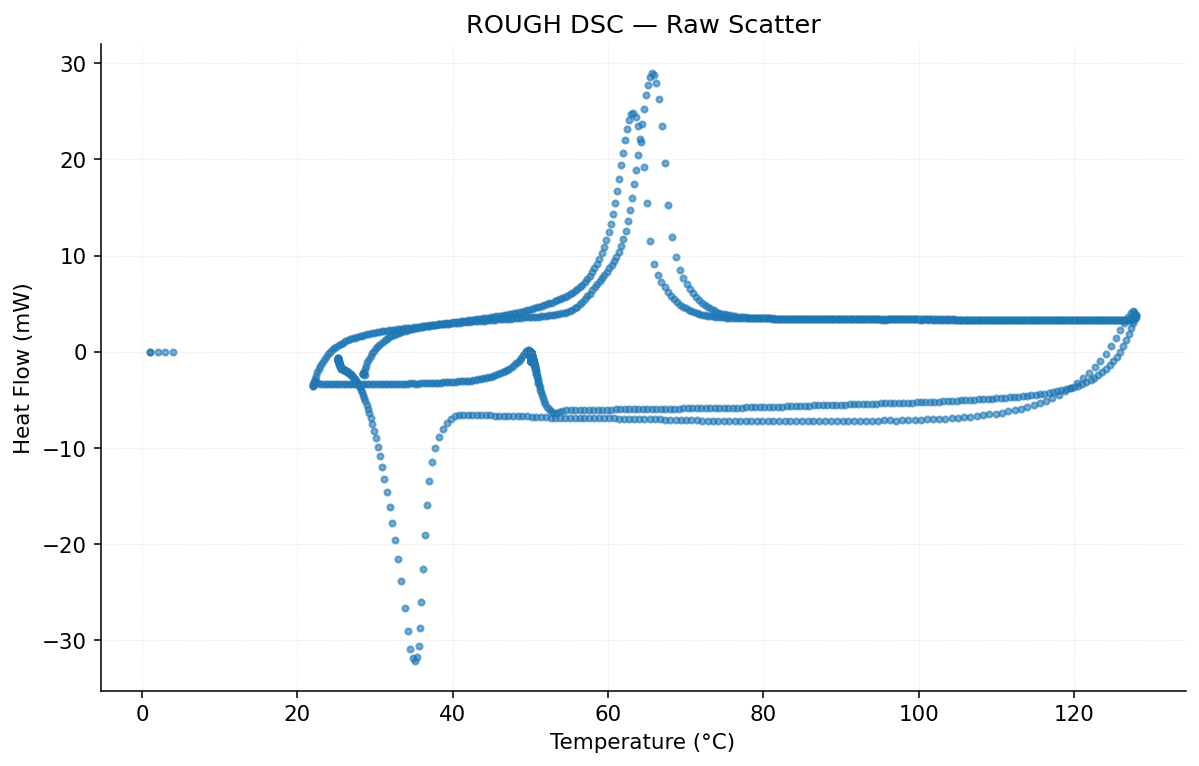

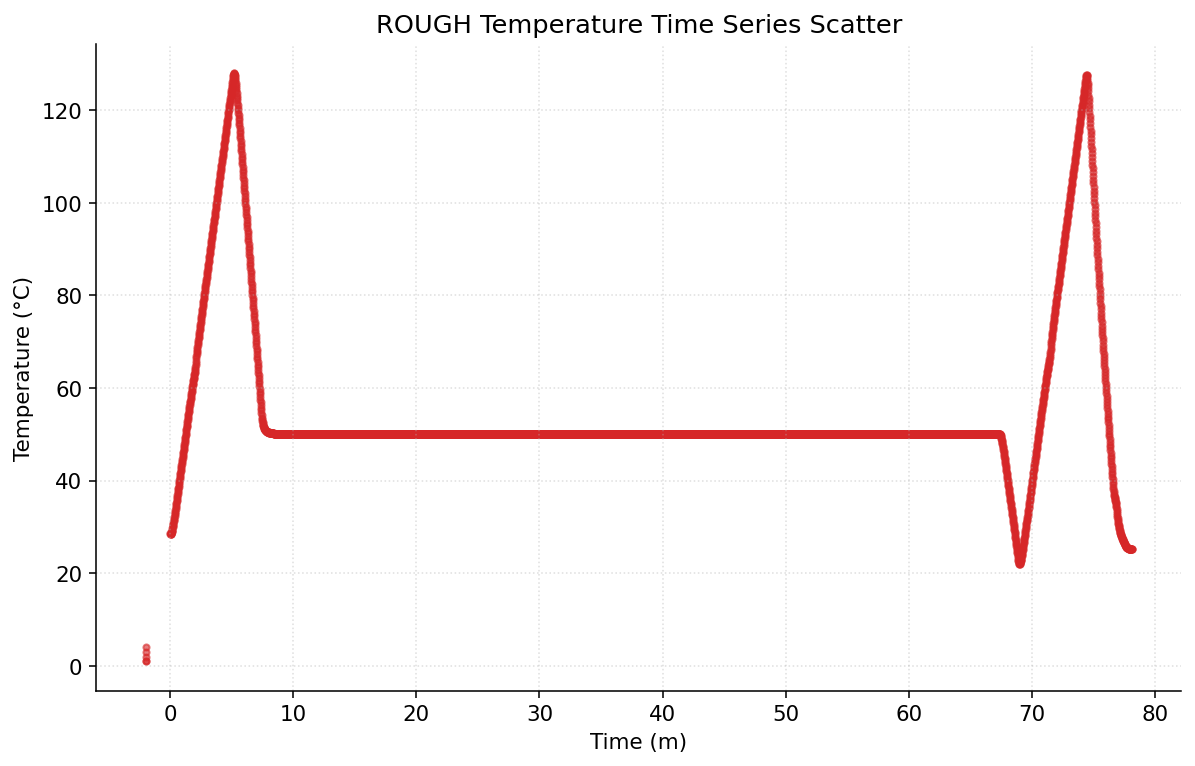

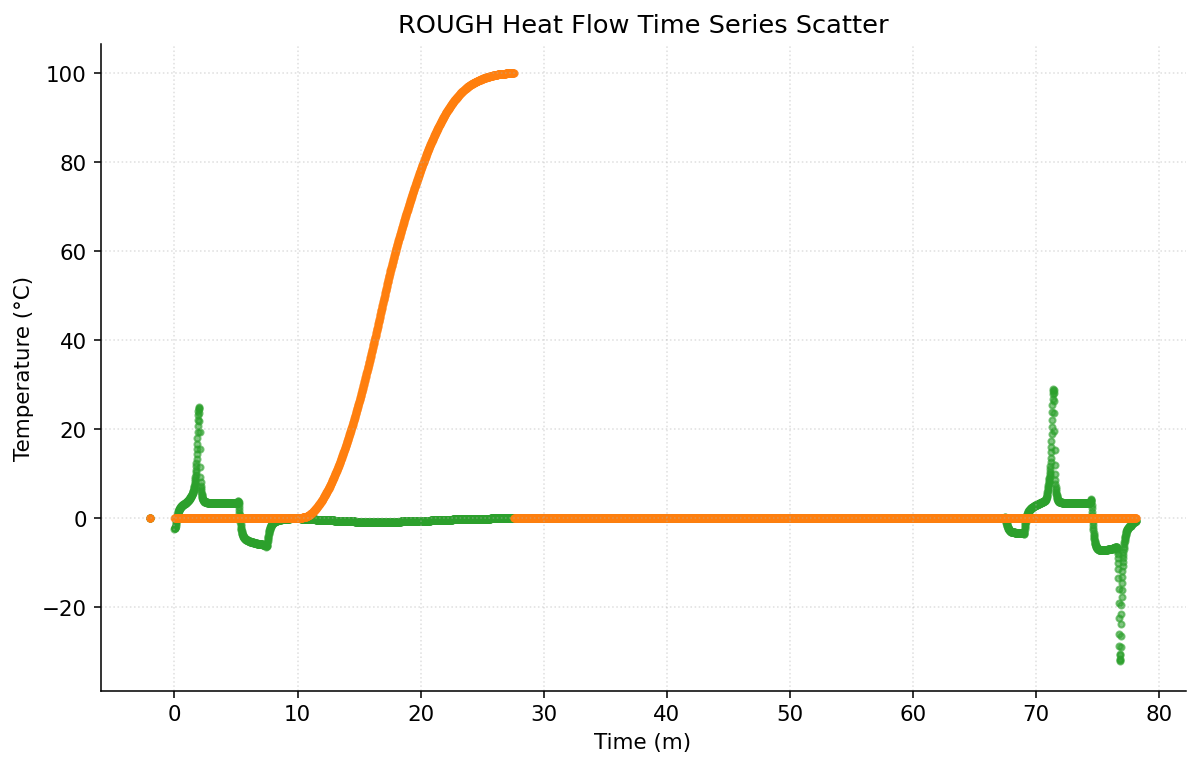

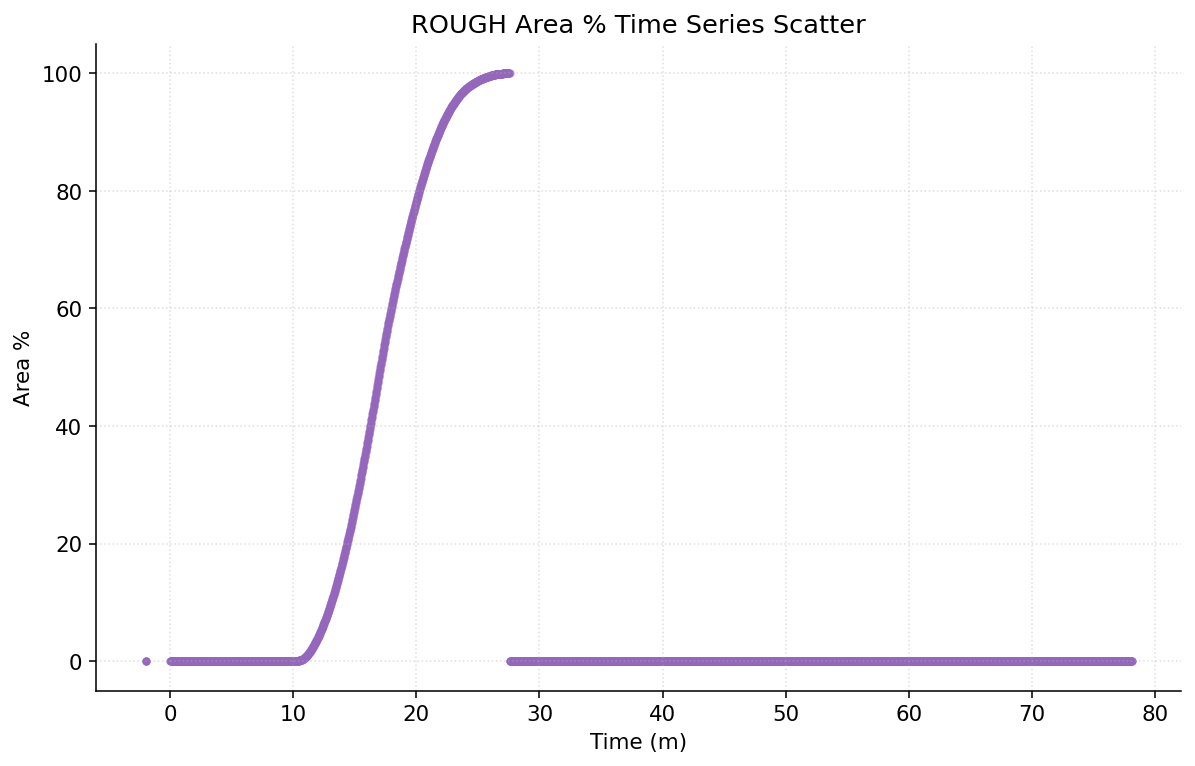

In [122]:
# Rough Scatter Plots to view raw data

plt.figure(figsize=(10, 6))
plt.scatter(T, HF, s=10, alpha=0.6, color='tab:blue')
plt.title('ROUGH DSC — Raw Scatter')
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (mW)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, T, s=10, alpha=0.6, color='tab:red')
plt.title('ROUGH Temperature Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, HF, s=10, alpha=0.6, color='tab:green')
plt.scatter(t, A, s=10, alpha=0.6, color='tab:orange')
plt.title('ROUGH Heat Flow Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, A, s=10, alpha=0.6, color='tab:purple')
plt.title('ROUGH Area % Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Area %')
plt.grid(True)
plt.show()

In [123]:
# Additional Processing based on plots

# Remove any rows where time is negative
df1 = df1[df1['Time/m'] >= 0].copy()
df1.reset_index(drop=True, inplace=True)

# Segment temperature and heat flow data into heating and cooling ramps
# ---------- 1) segment by monotonic temperature trend ----------
# tolerance to ignore tiny reversals at turning points
TEMP_EPS = 0.05   # °C; increase if you still get over-segmentation

dT = np.diff(T, prepend=T[0])
trend = np.sign(dT)  # -1 cooling, +1 heating, 0 flat

# squash small changes to 0, then forward-fill the last non-zero trend
trend[np.abs(dT) < TEMP_EPS] = 0
# forward fill trend so plateaus inherit previous direction
for i in range(1, len(trend)):
    if trend[i] == 0:
        trend[i] = trend[i-1]
# if the first values were zeros, fall back to next non-zero
if trend[0] == 0:
    nz = np.flatnonzero(trend)
    trend[0] = trend[nz[0]] if nz.size else 0

# boundaries where trend changes sign
cuts = np.where(np.diff(trend) != 0)[0] + 1
starts = np.r_[0, cuts]
ends   = np.r_[cuts, len(T)]

segments = []
for s, e in zip(starts, ends):
    seg_trend = int(np.sign(T[e-1] - T[s]))  # robust direction from endpoints
    if e - s < 10:     # drop tiny fragments
        continue
    if seg_trend == 0: # ignore flat holds
        continue
    seg_type = 'heating' if seg_trend > 0 else 'cooling'
    dT_span = abs(T[e-1] - T[s])
    npts = e - s
    segments.append({
        'start': s, 'end': e, 'type': seg_type,
        'span': dT_span, 'npts': npts
    })

# ---------- 2) pick the largest ramps ----------
TOP_K = 1  # keep the single largest heating and cooling; change to 2 if you want both cycles

# choose ranking metric: 'span' (temperature range) or 'npts' (duration)
RANK_BY = 'span'

heats  = sorted([seg for seg in segments if seg['type']=='heating'],
                key=lambda x: x[RANK_BY], reverse=True)[:TOP_K]
cools  = sorted([seg for seg in segments if seg['type']=='cooling'],
                key=lambda x: x[RANK_BY], reverse=True)[:TOP_K]

kept = heats + cools
kept = sorted(kept, key=lambda s: s['start'])  # optional: chronological order

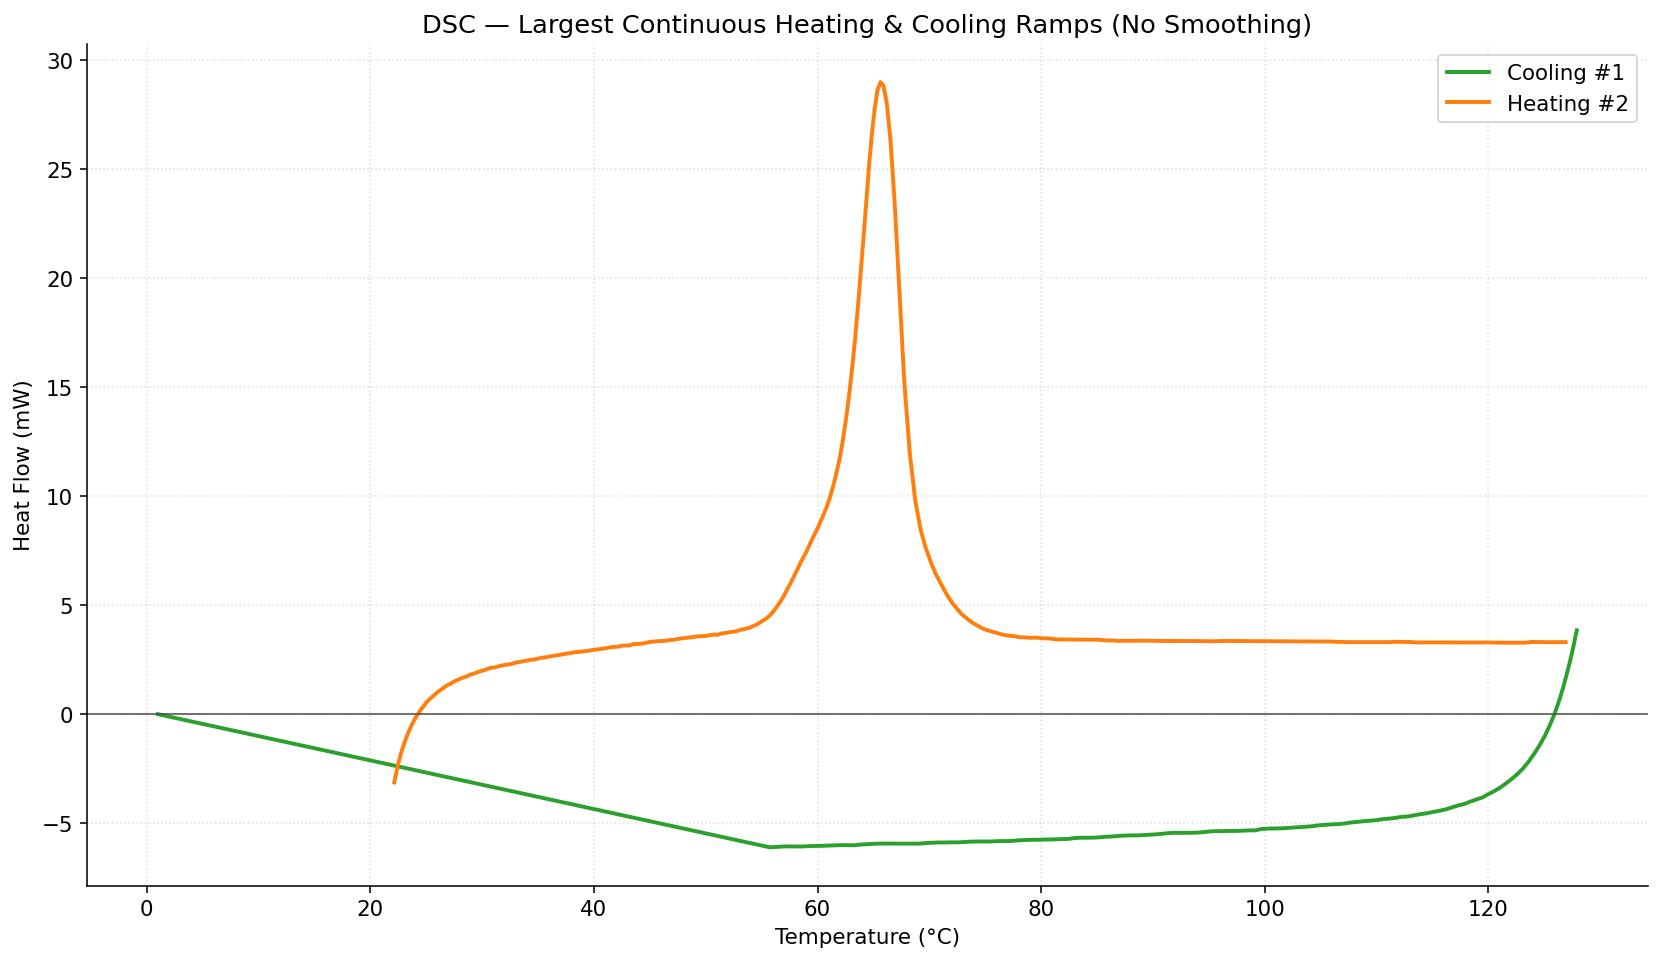

In [124]:
# Plot 1 - Highlighted largest heating and cooling ramps

plt.figure(figsize=(12, 7), dpi=140)
for i, seg in enumerate(kept, 1):
    sl = slice(seg['start'], seg['end'])
    color = '#ff7f0e' if seg['type']=='heating' else '#2ca02c'
    label = f"{seg['type'].title()} #{i if seg['type']=='heating' else i}"
    plt.plot(T[sl], HF[sl], color=color, lw=2.0, label=label)

plt.axhline(0, color='0.3', lw=0.8)
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (mW)')
plt.title('DSC — Largest Continuous Heating & Cooling Ramps (No Smoothing)')
plt.legend()
plt.tight_layout()
plt.show()

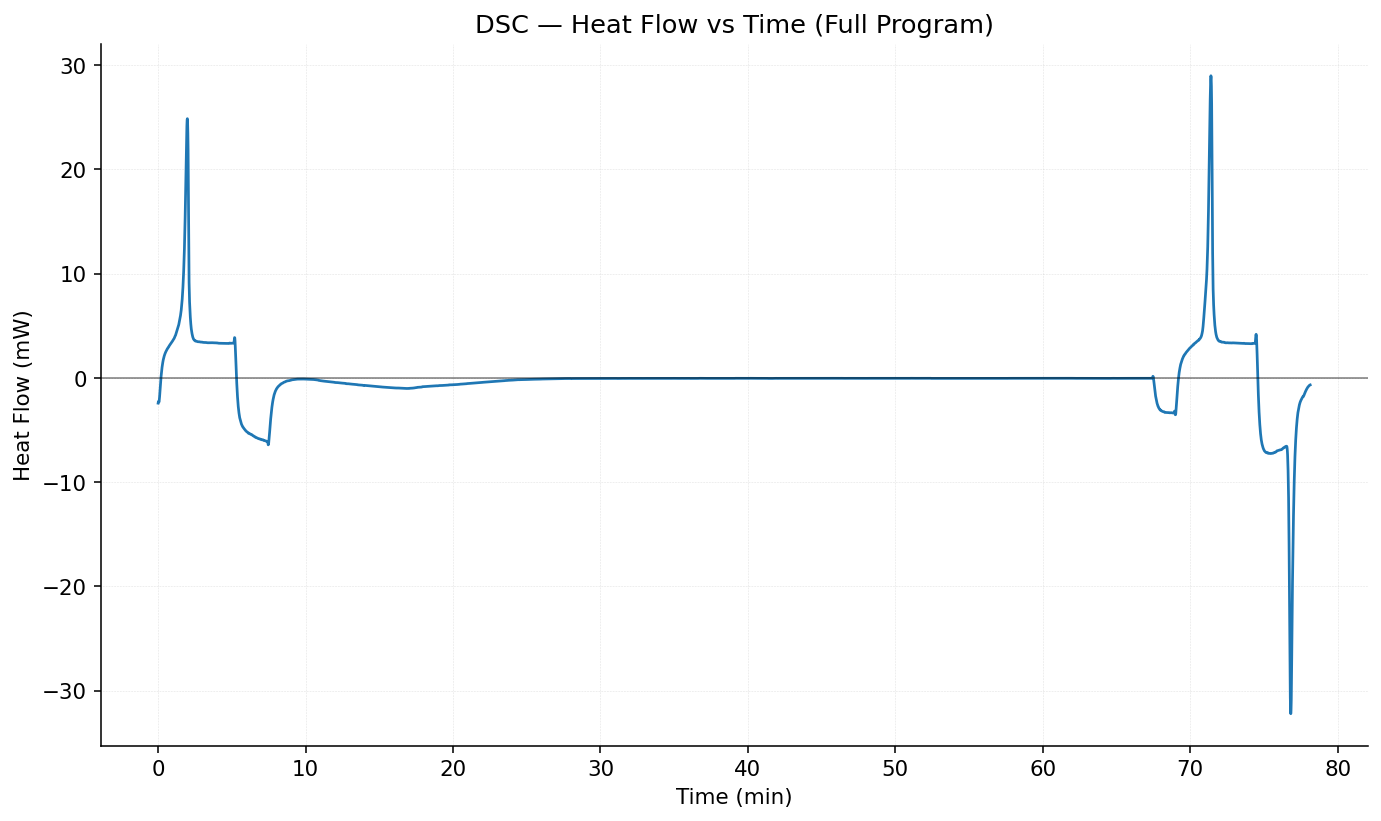

In [125]:
# Plot 2 - Heat flow time series (full data)

plt.figure(figsize=(10, 6), dpi=140)
plt.plot(df1['Time/m'], df1['Heat_Flow/mW'], color='tab:blue', lw=1.4)
plt.axhline(0, color='k', lw=0.8, alpha=0.5)
plt.title('DSC — Heat Flow vs Time (Full Program)')
plt.xlabel('Time (min)')
plt.ylabel('Heat Flow (mW)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

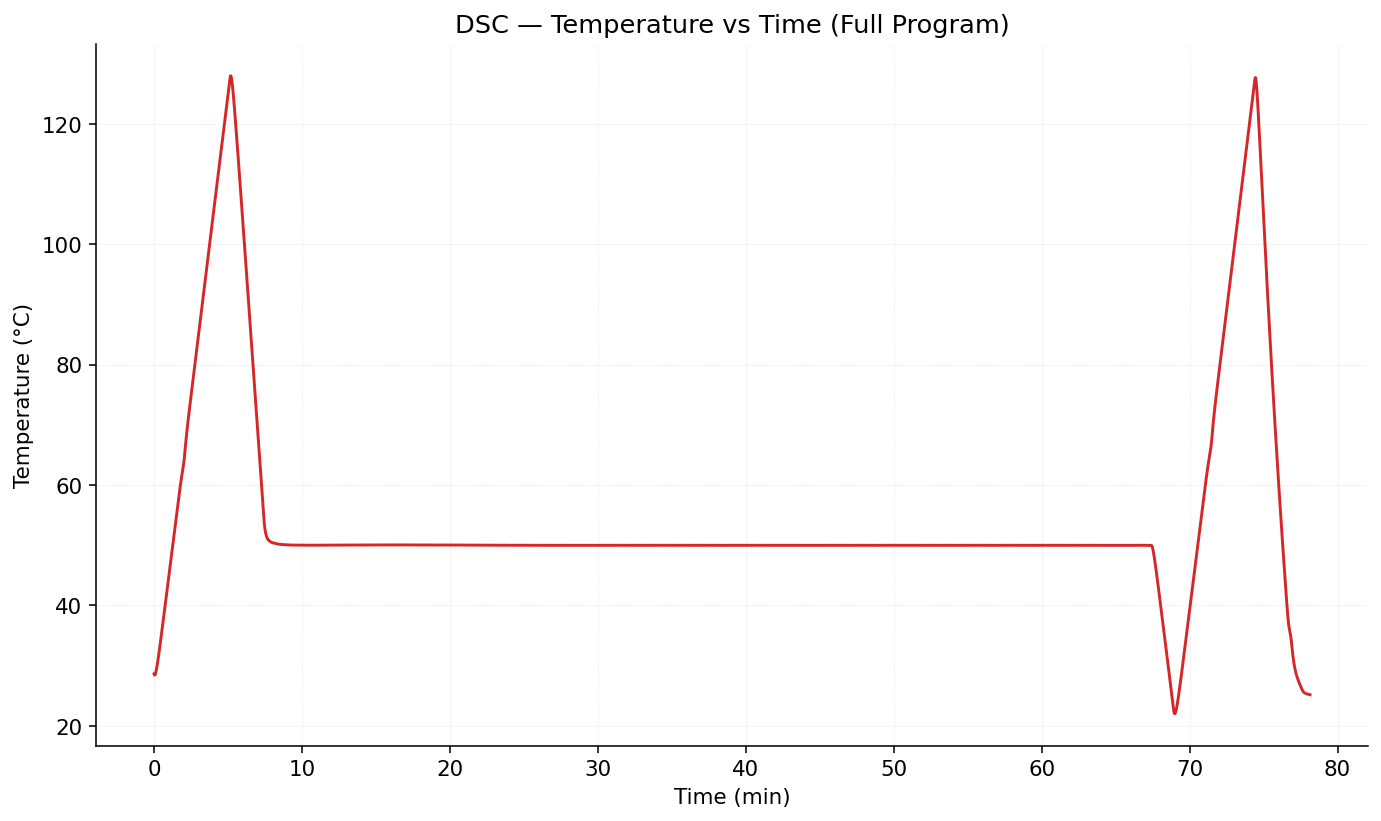

In [126]:
# Plot 3 - Temperature time series (full data)

plt.figure(figsize=(10, 6), dpi=140)
plt.plot(df1['Time/m'], df1['Temperature/C'], color='tab:red', lw=1.5)

plt.title('DSC — Temperature vs Time (Full Program)')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

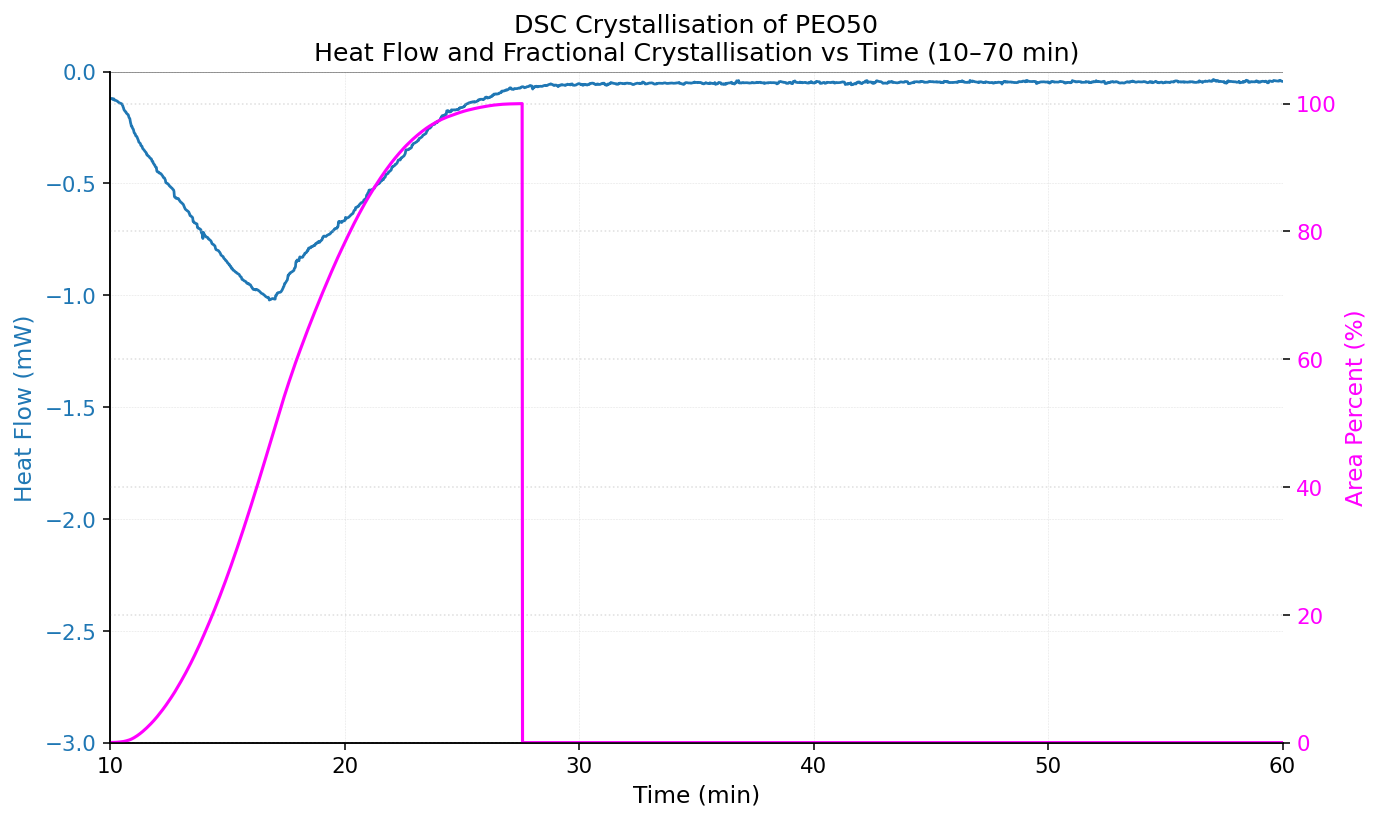

In [128]:
# --- Define the time window for this plot only ---
mask = (df1['Time/m'] >= 10) & (df1['Time/m'] <= 60)
df_window = df1.loc[mask].copy()

# --- Create dual-axis plot ---
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=140)

# Left y-axis → Heat Flow
ax1.plot(df_window['Time/m'], df_window['Heat_Flow/mW'],
         color='tab:blue', lw=1.4, label='Heat Flow (mW)')
ax1.set_xlabel('Time (min)', fontsize=12)
ax1.set_ylabel('Heat Flow (mW)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='k', lw=0.8, alpha=0.5)
ax1.grid(True, lw=0.3, alpha=0.6)

# Right y-axis → Area %
ax2 = ax1.twinx()
ax2.plot(df_window['Time/m'], df_window['Area/%'],
         color='magenta', lw=1.6, label='Area Percent (%)')
ax2.set_ylabel('Area Percent (%)', color='magenta', fontsize=12)
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.set_ylim(0, 105)

# --- Title and limits ---
ax1.set_xlim(10, 60)
ax1.set_ylim(-3,0)
plt.title('DSC Crystallisation of PEO50\nHeat Flow and Fractional Crystallisation vs Time (10–70 min)',
          fontsize=13)
fig.tight_layout()
plt.show()

In [129]:
#